In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'},
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import pandas as pd
import seaborn as sns 
import codecs, json

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.0.0


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
x_1 = np.linspace(-1,1,256)  # 256 points between -1 and 1 [256x1]
x_2 = np.linspace(1,-1,256)  # 256 points between 1 and -1 [256x1]

X, Y = np.meshgrid(x_1,x_2) 

# Test Data

We prepare the test data to compare against the solution produced by the PINN.

In [3]:
X_u_test = np.hstack((X.flatten(order='F')[:,None], Y.flatten(order='F')[:,None]))

# Domain bounds
lb = np.array([-1, -1]) #lower bound
ub = np.array([1, 1])  #upper bound

a_1 = 1 
a_2 = 4

usol = np.sin(a_1 * np.pi * X) * np.sin(a_2 * np.pi * Y) #solution chosen for convinience  

u = usol.flatten('F')[:,None] 

# Training Data

In [4]:
def trainingdata(N_u,N_f):
    
    leftedge_x = np.hstack((X[:,0][:,None], Y[:,0][:,None]))
    leftedge_u = usol[:,0][:,None]
    
    rightedge_x = np.hstack((X[:,-1][:,None], Y[:,-1][:,None]))
    rightedge_u = usol[:,-1][:,None]
    
    topedge_x = np.hstack((X[0,:][:,None], Y[0,:][:,None]))
    topedge_u = usol[0,:][:,None]
    
    bottomedge_x = np.hstack((X[-1,:][:,None], Y[-1,:][:,None]))
    bottomedge_u = usol[-1,:][:,None]
    
    all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x])
    all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])  
     
    #choose random N_u points for training
    idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) 
    
    X_u_train = all_X_u_train[idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[idx,:]      #choose corresponding u
    
    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    X_f = lb + (ub-lb)*lhs(2,N_f) 
    X_f_train = np.vstack((X_f, X_u_train)) # append training points to collocation points 
    
    return X_f_train, X_u_train, u_train 


# PINN 

$W \in \mathcal{R}^{n_{l-1}\times{n_l}}$ 

Creating sequential layers using the $\textit{class}$ tf.Module

In [5]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                        
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        #preprocessing input 
        x = (x - lb)/(ub - lb) #feature scaling
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        
        return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    def loss_PDE(self, x_to_train_f):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)

        k = 1    

        x_1_f = g[:,0:1]
        x_2_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_1_f)
            tape.watch(x_2_f)

            g = tf.stack([x_1_f[:,0], x_2_f[:,0]], axis=1)

            u = self.evaluate(g)
            u_x_1 = tape.gradient(u,x_1_f)
            u_x_2 = tape.gradient(u,x_2_f)

        u_xx_1 = tape.gradient(u_x_1,x_1_f)
        u_xx_2 = tape.gradient(u_x_2,x_2_f)

        del tape

        q = -( (a_1*np.pi)**2 + (a_2*np.pi)**2 - k**2 ) * np.sin(a_1*np.pi*x_1_f) * np.sin(a_2*np.pi*x_2_f)

        f = u_xx_1 + u_xx_2 + k**2 * u - q #residual
        
        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f, f
    
    def loss(self,x,y,g):

        loss_u = self.loss_BC(x,y)
        loss_f, f_plot = self.loss_PDE(g)

        loss = loss_u + loss_f

        return loss, loss_u, loss_f 
    
    
    def gradients(self,x,y,x_train_f):
        
        with tf.GradientTape() as tape:
            tape.watch(self.W)
            loss_val, loss_u, loss_f = self.loss(x, y, x_train_f)
            
        grads = tape.gradient(loss_val,self.W)
            
        del tape

        return loss_val, loss_u, loss_f, grads
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u-u_pred),2)/np.linalg.norm(u,2)
        
        tf.print(loss_value, loss_u, loss_f, error_vec)

# *Loss Function*

The loss function consists of two parts:
1. **loss_BC**: MSE error of boundary losses
2. **loss_PDE**: MSE error of collocation points satisfying the PDE

**loss** = loss_BC + loss_PDE

84.66349767318421 0.00081795983022750983 84.662679713353981 1.0122059775370291
Training time: 2.87
Test Error: 1.00713


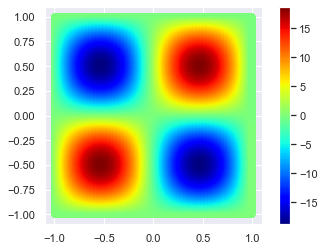

In [113]:
N_u = 400 #Total number of data points for 'u'
N_f = 100000 #Total number of collocation points 

# Training data
X_f_train, X_u_train, u_train = trainingdata(N_u,N_f)

layers = np.array([2, 50, 50, 50, 1]) #3 hidden layers

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

num_epochs = 4e4

batch_size = 128

for epoch in range(int(num_epochs)):
    
    idx = np.random.choice(X_u_train.shape[0], batch_size, replace=False)
    
    loss_value, loss_u, loss_f, grads = PINN.gradients(X_u_train[idx], u_train[idx], X_f_train[idx])

    optimizer.apply_gradients(zip(grads, PINN.W)) #gradient descent
        
    if epoch % 100 == 0:

        u_pred = PINN.evaluate(X_u_test)
        error_vec = np.linalg.norm((u-u_pred),2)/np.linalg.norm(u,2)        # Relative L2 Norm of the error (Vector)

        tf.print(loss_value, loss_u, loss_f, error_vec)
        
        
elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u-u_pred),2)/np.linalg.norm(u,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))

u_pred = np.reshape(u_pred,(256,256),order='F') 

# #Plot and save image
# plt.pcolor(x_1,x_2,u_pred, cmap = 'jet')
# plt.axis('scaled')
# plt.colorbar()
# plt.savefig('Stiff_Helmholtz.png', dpi = 500)

# #Error plot
# plt.pcolor(x_1,x_2,usol-u_pred, cmap = 'jet')
# plt.axis('scaled')
# plt.colorbar()
# plt.savefig('Stiff_Helmholtz_error.png', dpi = 500)

# #Residual plot
# loss_f, f_plot = PINN.loss_PDE(X_u_test)
# plt.scatter(X_u_test[:,0:1],X_u_test[:,1:2],c=f_plot, cmap = 'jet')
# plt.axis('scaled')
# plt.colorbar()
# plt.savefig('Stiff_Helmholtz_residual.png', dpi = 500)

In [ ]:
with tf.GradientTape(persistent=True) as tape:
    loss_value, loss_u, loss_f = PINN.loss(X_u_train, u_train, X_f_train)
    grad_u = tape.gradient(loss_u, PINN.W) 
    grad_f = tape.gradient(loss_f, PINN.W)
    del tape

In [ ]:
#Writing gradients to 2 separate JSON files 

L = len(layers)-1 #number of weights matrices

for i in range (L*2):

    temp = grad_f[i].numpy().tolist() # nested lists with same data, indices
    json.dump(temp, codecs.open("Non_Stiff_problem/Gradients/gradients_f" + str(i) + ".json", 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=True, indent=0)
    
    temp = grad_u[i].numpy().tolist() # nested lists with same data, indices
    json.dump(temp, codecs.open("Non_Stiff_problem/Gradients/gradients_u" + str(i) + ".json", 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=True, indent=0)

In [87]:
f_1 = {} #residual non-stiff problem
u_1 = {} #boundary non-stiff problem

f_2 = {} #residual stiff problem
u_2 = {} #boundary stiff problem

L = 4

#Reading gradients from JSON files and storing in a dict 
#storing gradients of both weights and biases

for i in range (L):
    
    #weights and biases
#     obj_text_w = codecs.open("Non_Stiff_problem/Gradients/gradients_f" + str(2*i) + ".json", 'r', encoding='utf-8').read()
#     obj_text_b = codecs.open("Non_Stiff_problem/Gradients/gradients_f" + str(2*i+1) + ".json", 'r', encoding='utf-8').read()
#     f_1['f'+ str(i)] = np.concatenate((np.array(json.loads(obj_text_w)).flatten('F'), np.array(json.loads(obj_text_b)).flatten('F')))
    
#     obj_text_w = codecs.open("Non_Stiff_problem/Gradients/gradients_u" + str(2*i) + ".json", 'r', encoding='utf-8').read()
#     obj_text_b = codecs.open("Non_Stiff_problem/Gradients/gradients_u" + str(2*i+1) + ".json", 'r', encoding='utf-8').read()
#     u_1['u'+ str(i)] = np.concatenate((np.array(json.loads(obj_text_w)).flatten('F'), np.array(json.loads(obj_text_b)).flatten('F')))
    
    obj_text_w = codecs.open("Stiff_problem/Gradients/gradients_f" + str(2*i) + ".json", 'r', encoding='utf-8').read()
    obj_text_b = codecs.open("Stiff_problem/Gradients/gradients_f" + str(2*i+1) + ".json", 'r', encoding='utf-8').read()
    f_2['f'+ str(i)] = np.concatenate((np.array(json.loads(obj_text_w)).flatten('F'), np.array(json.loads(obj_text_b)).flatten('F')))
    
    obj_text_w = codecs.open("Stiff_problem/Gradients/gradients_u" + str(2*i) + ".json", 'r', encoding='utf-8').read()
    obj_text_b = codecs.open("Stiff_problem/Gradients/gradients_u" + str(2*i+1) + ".json", 'r', encoding='utf-8').read()
    u_2['u'+ str(i)] = np.concatenate((np.array(json.loads(obj_text_w)).flatten('F'), np.array(json.loads(obj_text_b)).flatten('F')))
    
    
#     #only weights
#     obj_text_w = codecs.open("Non_Stiff_problem/Gradients/gradients_f" + str(2*i) + ".json", 'r', encoding='utf-8').read()
#     f_1['f'+ str(i)] = np.array(json.loads(obj_text_w)).flatten('F')
    
#     obj_text_w = codecs.open("Non_Stiff_problem/Gradients/gradients_u" + str(2*i) + ".json", 'r', encoding='utf-8').read()
#     u_1['u'+ str(i)] = np.array(json.loads(obj_text_w)).flatten('F')
    
#     obj_text_w = codecs.open("Stiff_problem/Gradients/gradients_f" + str(2*i) + ".json", 'r', encoding='utf-8').read()
#     f_2['f'+ str(i)] = np.array(json.loads(obj_text_w)).flatten('F')
    
#     obj_text_w = codecs.open("Stiff_problem/Gradients/gradients_u" + str(2*i) + ".json", 'r', encoding='utf-8').read()
#     u_2['u'+ str(i)] = np.array(json.loads(obj_text_w)).flatten('F')

In [6]:
#Plot the gradients
#seaborn = 0.9.0

cnt = 1
fig = plt.figure(4, figsize=(13, 4))

for i in range (L):
    
    ax = plt.subplot(1, 4, cnt)
    ax.set_title('Layer {}'.format(i + 1))
    ax.set_yscale('symlog')
    
    gradients_res = f_1['f'+ str(i)]
    gradients_bcs = u_1['u'+ str(i)]
      
    sns.distplot(gradients_bcs, hist=False,
                 kde_kws={"shade": False},
                 norm_hist=False, label=r'$\nabla_{\theta} \hat J_{BC}$')
    
    sns.distplot(gradients_res, hist=False,
                 kde_kws={"shade": False},
                 norm_hist=False, label=r'$\nabla_{\theta} \hat J_{PDE}$')

    ax.get_legend().remove()
    ax.set_xlim([-3, 3])
    ax.set_ylim([0,1e6])
    cnt += 1
    
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left", bbox_to_anchor=(0.35, -0.01),
             borderaxespad=0, bbox_transform=fig.transFigure, ncol=2)
plt.tight_layout()
plt.show()

fig.savefig('Gradient_histogram_stiff_Adam.png', dpi = 500, bbox_inches='tight')

NameError: name 'L' is not defined

<Figure size 936x288 with 0 Axes>